In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import joblib

In [2]:
ruta_carpeta = "D:/Machine Learning/Proyectos/Micro_Gas_Turbine_Prediction/data/train"

#Obtener la lista de archivos
patron = os.path.join(ruta_carpeta, "ex_*.csv")
archivos = glob.glob(patron)

# 2. Función para ordenarlos lógicamente (1, 9, 20, 21...)
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

archivos.sort(key=natural_sort_key)

# 3. Cargar en el diccionario
# Usamos os.path.splitext para que la llave sea solo 'ex_1', 'ex_9', etc.
datasets = {os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f) for f in archivos}

# 4. Confirmación
print("Orden de carga final:")
print(list(datasets.keys()))

Orden de carga final:
['ex_1', 'ex_9', 'ex_20', 'ex_21', 'ex_23', 'ex_24']


In [3]:
#Verificamos que todos los archivos contengan las mismas columnas
for nombre, df in datasets.items():
    print(f"Columnas en {nombre}:")
    print(list(df.columns))
    print("-" * 20)

Columnas en ex_1:
['time', 'input_voltage', 'el_power']
--------------------
Columnas en ex_9:
['time', 'input_voltage', 'el_power']
--------------------
Columnas en ex_20:
['time', 'input_voltage', 'el_power']
--------------------
Columnas en ex_21:
['time', 'input_voltage', 'el_power']
--------------------
Columnas en ex_23:
['time', 'input_voltage', 'el_power']
--------------------
Columnas en ex_24:
['time', 'input_voltage', 'el_power']
--------------------


In [4]:
columna_interes = 'el_power' 

for nombre, df in datasets.items():
    if columna_interes in df.columns:
        promedio = df[columna_interes].mean()
        print(f"Promedio {columna_interes} en {nombre}: {promedio:.2f}")

Promedio el_power en ex_1: 2162.43
Promedio el_power en ex_9: 1828.55
Promedio el_power en ex_20: 1623.26
Promedio el_power en ex_21: 1576.46
Promedio el_power en ex_23: 1899.23
Promedio el_power en ex_24: 1805.38


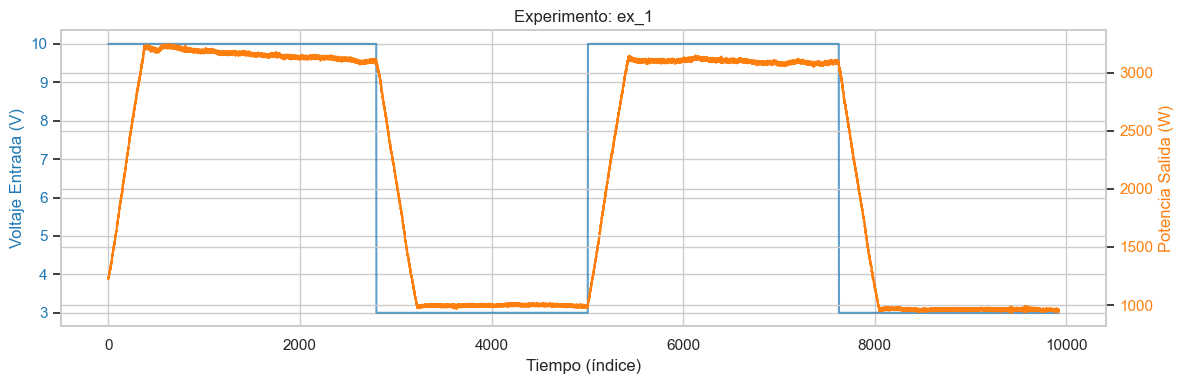

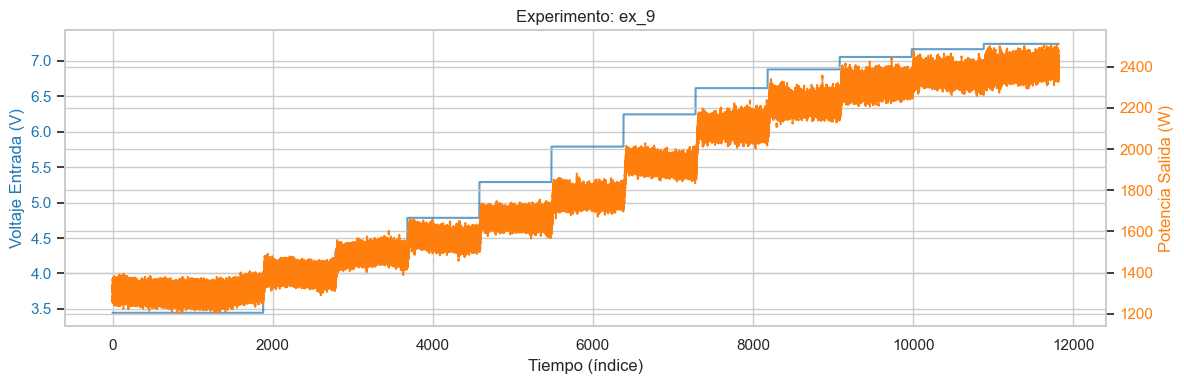

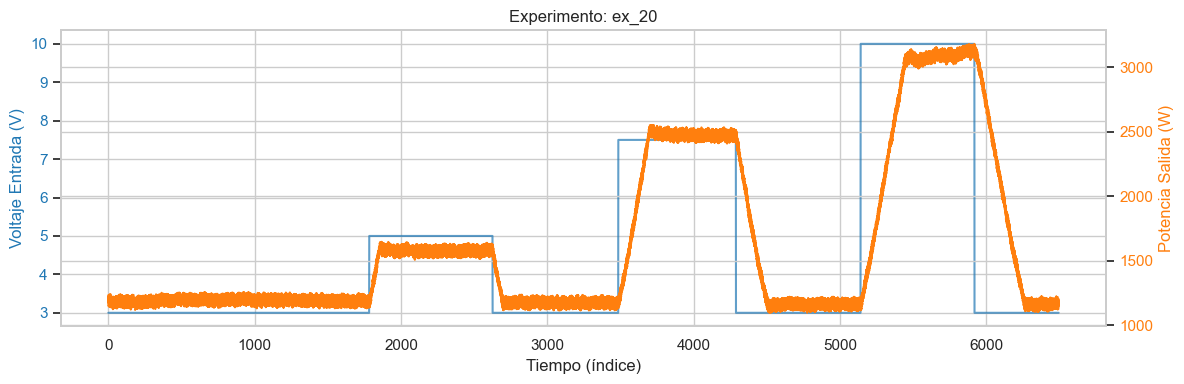

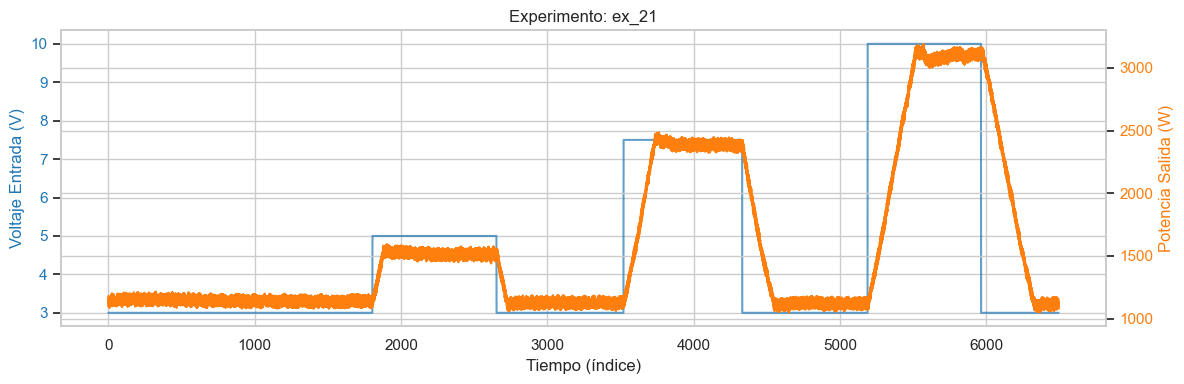

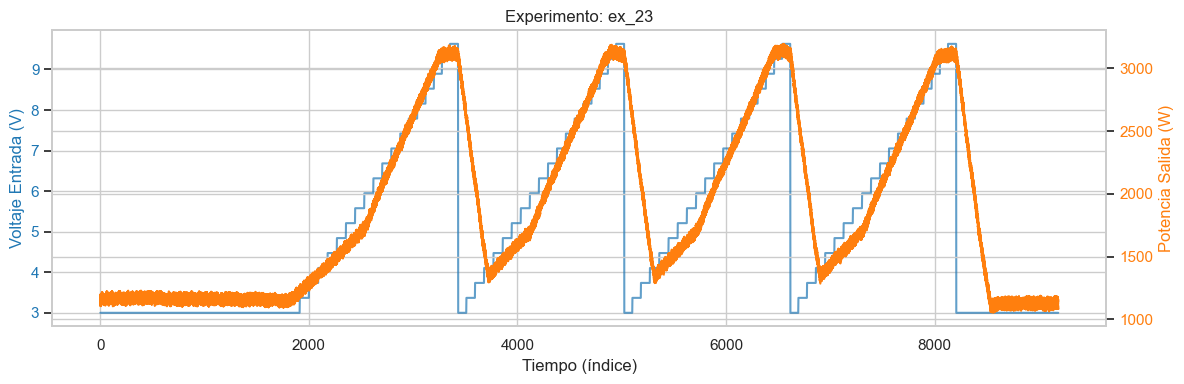

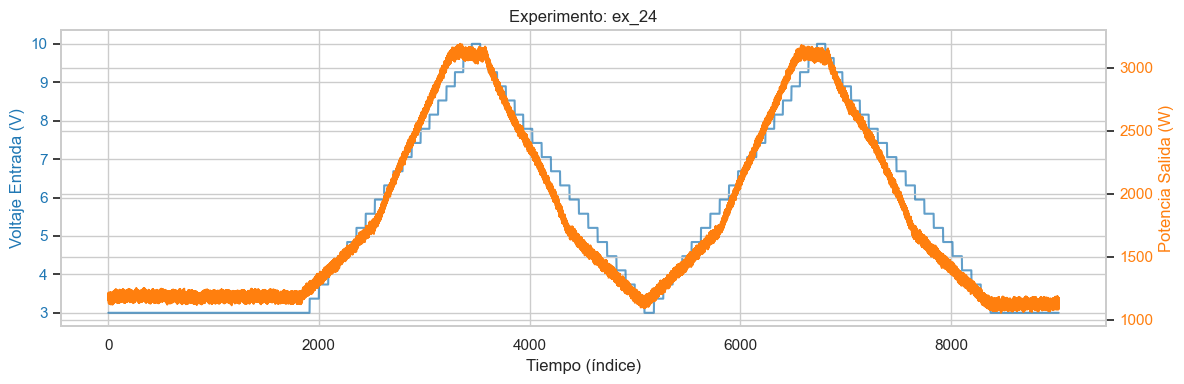

In [5]:
# Configuración estética
sns.set_theme(style="whitegrid")

def visualizar_series(diccionario_datos):
    """
    Recorre el diccionario datasets y grafica.
    """
    for nombre, df in diccionario_datos.items():
        fig, ax1 = plt.subplots(figsize=(12, 4))
        
        # Eje izquierdo: Voltaje (Input)
        color = 'tab:blue'
        ax1.set_xlabel('Tiempo (índice)')
        ax1.set_ylabel('Voltaje Entrada (V)', color=color)
        ax1.plot(df.index, df['input_voltage'], color=color, label='Voltaje', alpha=0.7)
        ax1.tick_params(axis='y', labelcolor=color)
        
        # Eje derecho: Potencia (Output)
        ax2 = ax1.twinx()  
        color = 'tab:orange'
        ax2.set_ylabel('Potencia Salida (W)', color=color)
        ax2.plot(df.index, df['el_power'], color=color, label='Potencia', linestyle='--')
        ax2.tick_params(axis='y', labelcolor=color)
        
        plt.title(f'Experimento: {nombre}')
        fig.tight_layout()  
        plt.show()

# --- ESTA ES LA LÍNEA QUE FALTABA ---
# Llamamos a la función pasándole tu variable 'datasets'
visualizar_series(datasets) 

1. Dinámica de Respuesta: Comportamiento de Primer Orden. Se observa que la potencia no cambia instantaneamente. Cunaod el voltaje sube en "escalón" (como en ex_1 o ex_2), la potencia sigue una curva de crecimiento exponencial hasta estabilizarse. Conclusión: El sistema tiene inercia o capacitancia térmico-mecánica. Hay un tiempo de respuesta (Time Constant) que el modelo de ML deberá aprender para predecir cuándo la potencia alcanzará el estado estacionario.
2. Relación Voltaje vs Potencia (Ganancia del Sistema):
    * Voltaje Mínimo: Con 3V de entrada, la turbina opera en un "piso" de potencia cercano a los 1100W-1200W.
    * Voltaje Máximo: Con 10V, la potencia llega a su tope cerca de los 3200W.
    * Linealidad: Al observar ex_9 (los escalones ascendentes), la respuesta parece bastante lineal, aunque hay un ligero aumento del ruido (vibraciones/inestabilidad) a medida que la potencia aumenta.
3. Diferencias en los Experimentos (Regimenes de Carga): Cada gráfico representa una prueba de estrés distinta para la turbina:
    * ex_1: Muestra la respuesta a cambios bruscos y estabilidad a largo plazo en carga alta y baja.
    * ex_9: Es ideal para mapear la curva de eficiencia, ya que recorre todos los puntos de operación de forma escalonada.
    * ex_20 y ex_21: Son casi idénticos, lo que sugiere repetibilidad en el sistema. Es bueno que el modelo vea que ante el msmo estímulo, la turbina responde igual.
    * ex_23 y ex_24. Son perfiles de rampa (triangulares). Aquí se puede analizar Histeresis: ¿La turbina entrega la misma potencia cuando el voltaje está subiendo a 6V que cuando está bajando a 6V?
4. Presencia de Ruido y Estacionariedad: La señal naranja (Potencia) tiene un componente de alta frecuencia (ruido). Para usr modelos de series temporales como ARIMA o LSTM, se podría evaluar si ese ruido es información relevante (vibración real) o si se necesita aplicar un filtro de media móvil para suavizar la señal antes de entrenar.    


Lag óptimo para ex_1: 100 pasos
Lag óptimo para ex_9: 0 pasos
Lag óptimo para ex_20: 100 pasos
Lag óptimo para ex_21: 100 pasos
Lag óptimo para ex_23: 100 pasos
Lag óptimo para ex_24: -20 pasos


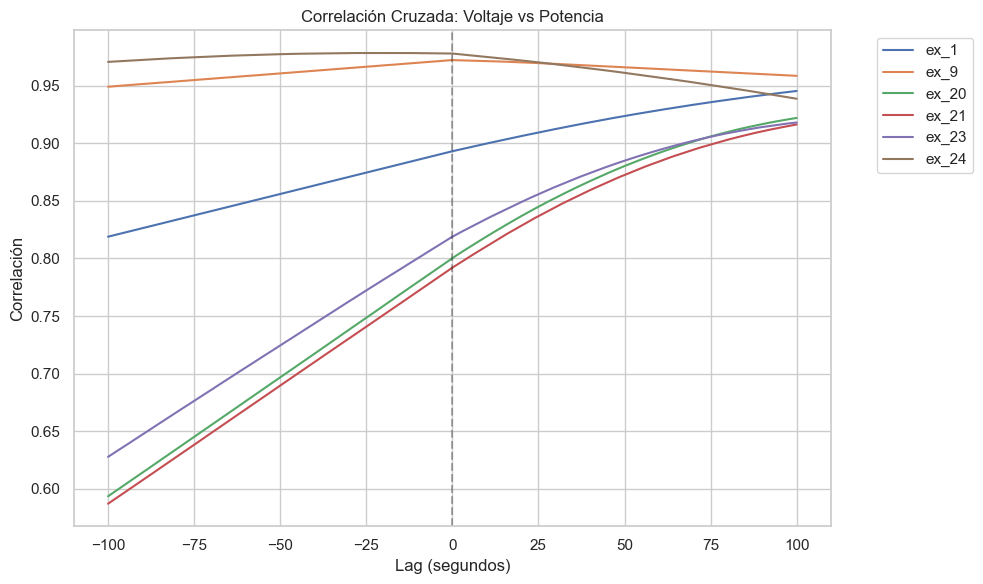

In [ ]:
def plot_cross_correlation(diccionario_datos, max_lag=200):
    """
    Calcula la correlación cruzada entre voltaje y potencia para encontrar el delay.
    """
    lags_optimos = {}
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for nombre, df in diccionario_datos.items():
        # Normalizamos para que la escala sea comparable
        v = df['input_voltage'] - df['input_voltage'].mean()
        p = df['el_power'] - df['el_power'].mean()
        v = v / v.std()
        p = p / p.std()
        
        # Cross-Correlation
        corr = correlate(p, v, mode='full')
        lags = np.arange(-len(v) + 1, len(v))
        
        # Recortamos para ver solo la ventana interesante (ej. +/- 200 segundos)
        mask = (lags >= -max_lag) & (lags <= max_lag)
        corr_recortado = corr[mask] / len(v) # Normalizado por longitud
        lags_recortado = lags[mask]
        
        ax.plot(lags_recortado, corr_recortado, label=f'{nombre}')
        
        # Encontrar el pico máximo (Lag óptimo)
        lag_optimo = lags_recortado[np.argmax(corr_recortado)]
        lags_optimos[nombre] = lag_optimo
        print(f"Lag óptimo para {nombre}: {lag_optimo} pasos")

    ax.set_title('Correlación Cruzada: Voltaje vs Potencia')
    ax.set_xlabel('Lag (segundos)')
    ax.set_ylabel('Correlación')
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return lags_optimos

# Ejecutar
lags_detectados = plot_cross_correlation(datasets, max_lag=100)

1. Dinámica de Retraso (Lag Temporal): La mayoría de los experimentos muestran un lag óptimo de 100 pasos. Existe un desfase temporal significativo entre la entrada (voltaje) y la salida (potencia). Esto es típico en sistemas térmicos y mecánicos con inercia.
2. El caso atipioco (ex_9): Muestra un lag de 0 pasos, al observar la gráfica los cambios de voltaje con escalonados muy pequeños y lentos. Cuando los cambios son suaves, el sistema parece responder "instantáneamente" porque el tiempo de estabilización es menor al tamaño del escalón.
3. Histéresis y Respues No Lineal (ex_24): El lago de -20 pasos es curioso. En procesamiento de señales, un lag negativo suele indicar que la señal de salida parece "adelantarse" o que existe una fuerte asimetría entre la subida y la bajada. Es muy probable que la turbina no responda igual cuando acelera y cuando desacelera (histéresis). Esto es común por la retención de calor en la cámara de combustión.
4. Estabilidad y Ruido:
    * Banda de Ruido: La potencia tiene una banda de fluctuación (ruido blanco) constante de aproximadamente 100W-200W.
    * Estado Estacionario: Una vez que la potencia alcanza el nuevo nivel de voltaje, se mantiene estable (estacionaria), lo que indica que el sistema de control interno de la turbina es robusto.

In [7]:
def crear_features(diccionario_datos):
    """
    Genera features de retardos (lags) y medias móviles.
    """
    diccionario_procesado = {}
    
    for nombre, df_raw in diccionario_datos.items():
        df = df_raw.copy()
        
        # --- 1. Lags de Voltaje (Causa) ---
        # Basado en tu hallazgo de que el lag óptimo es ~100
        df['voltage_lag10'] = df['input_voltage'].shift(10)
        df['voltage_lag50'] = df['input_voltage'].shift(50)
        df['voltage_lag100'] = df['input_voltage'].shift(100) # El crítico
        
        # --- 2. Lags de Potencia (Inercia/Autoregresión) ---
        df['power_lag1'] = df['el_power'].shift(1)
        df['power_lag2'] = df['el_power'].shift(2)
        
        # --- 3. Rolling Statistics (Para el Ruido) ---
        # Usamos shift(1) para asegurar que el promedio NO incluya el valor actual (Data Leakage)
        df['power_rolling_mean'] = df['el_power'].shift(1).rolling(window=10).mean()
        
        # --- 4. Limpieza ---
        # Eliminamos las primeras 100 filas que ahora tienen NaN
        df.dropna(inplace=True)
        
        diccionario_procesado[nombre] = df
        
    return diccionario_procesado

# Ejecutar
datasets_procesados = crear_features(datasets)

# Verifiquemos las nuevas columnas
print(datasets_procesados['ex_1'].head())

          time  input_voltage     el_power  voltage_lag10  voltage_lag50  \
100  909.98028             10  1741.653976           10.0           10.0   
101  910.97938             10  1728.004362           10.0           10.0   
102  911.97848             10  1751.309460           10.0           10.0   
103  912.97758             10  1746.394136           10.0           10.0   
104  913.97668             10  1762.558340           10.0           10.0   

     voltage_lag100   power_lag1   power_lag2  power_rolling_mean  
100            10.0  1713.098165  1723.551567         1702.370675  
101            10.0  1741.653976  1713.098165         1709.118155  
102            10.0  1728.004362  1741.653976         1712.728059  
103            10.0  1751.309460  1728.004362         1719.714431  
104            10.0  1746.394136  1751.309460         1724.083812  


In [ ]:
def preparar_datos_finales(diccionario_procesado):
    """
    Concatena todos los dataframes y separa X (features) e y (target).
    """
    # 1. Concatenar todo en vertical
    df_completo = pd.concat(diccionario_procesado.values(), ignore_index=True)
    
    # 2. Separar Target y Features
    y = df_completo['el_power']
    
    # Quitamos 'el_power' (porque es lo que queremos predecir) y 'time' (no es predictivo por sí solo)
    # También conservamos 'input_voltage' original o lo quitamos si confiamos solo en los lags? 
    # Generalmente se deja 'input_voltage' (que es lag 0)
    features_a_borrar = ['el_power', 'time']
    X = df_completo.drop(columns=[c for c in features_a_borrar if c in df_completo.columns])
    
    return X, y

# --- Ejecutar ---
X_raw, y = preparar_datos_finales(datasets_procesados)

# 3. Normalización (StandardScaler)
# Importante: Guardamos el 'scaler' para poder usarlo luego con datos nuevos
scaler = StandardScaler()

# fit_transform calcula la media y desv. est. y transforma los datos
X_scaled_array = scaler.fit_transform(X_raw)

# Lo convertimos de nuevo a DataFrame para no perder los nombres de las columnas
X_final = pd.DataFrame(X_scaled_array, columns=X_raw.columns)

print(f"Dimensiones Finales: {X_final.shape}")
print("Primeras filas normalizadas:")
print(X_final.head())

Dimensiones Finales: (52340, 7)
Primeras filas normalizadas:
   input_voltage  voltage_lag10  voltage_lag50  voltage_lag100  power_lag1  \
0       1.759818       1.759187       1.756667        1.753528   -0.189350   
1       1.759818       1.759187       1.756667        1.753528   -0.149919   
2       1.759818       1.759187       1.756667        1.753528   -0.168767   
3       1.759818       1.759187       1.756667        1.753528   -0.136586   
4       1.759818       1.759187       1.756667        1.753528   -0.143373   

   power_lag2  power_rolling_mean  
0   -0.174912           -0.204549  
1   -0.189347           -0.195213  
2   -0.149915           -0.190218  
3   -0.168764           -0.180552  
4   -0.136582           -0.174506  


Entrenando XGBoost...
--- Resultados del Modelo ---
RMSE (Error Promedio): 10.37 Watts
R2 Score (Precisión): 0.9998 (El máximo es 1.0)


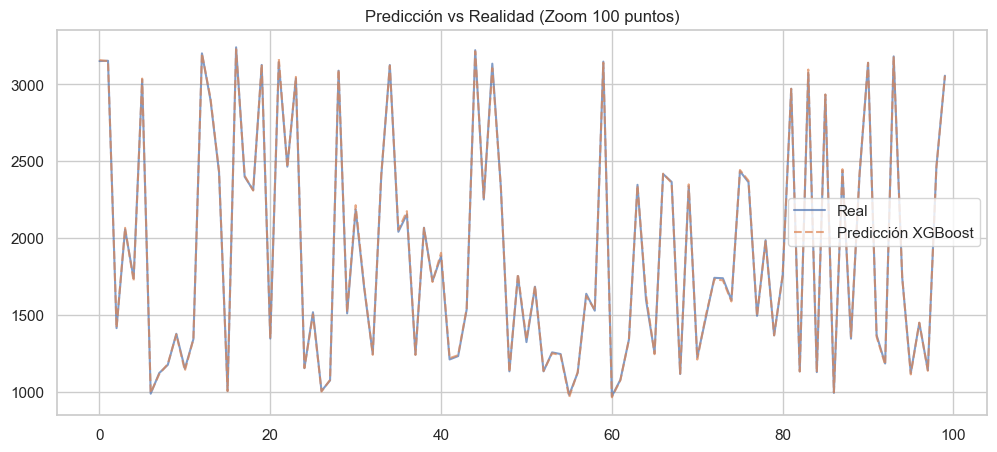

In [ ]:
# 1. Split rápido para validación (80% entrenar, 20% validar)
# shuffle=False es IMPORTANTE en series temporales si fuera una sola serie
# Pero como son multiples experimentos concatenados, shuffle=True es aceptable 
# SIEMPRE Y CUANDO no busquemos predecir el futuro lejano, sino la respuesta del sistema.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_final, y, test_size=0.2, random_state=42, shuffle=True
)

# 2. Entrenar Modelo
print("Entrenando XGBoost...")
model = XGBRegressor(
    n_estimators=100,  # Número de árboles
    learning_rate=0.1, # Velocidad de aprendizaje (menor es más preciso pero más lento)
    max_depth=6,       # Profundidad de los árboles
    n_jobs=-1          # Usar todos los procesadores
)

model.fit(X_train_split, y_train_split)

# 3. Predecir y Evaluar
preds = model.predict(X_val_split)

rmse = np.sqrt(mean_squared_error(y_val_split, preds))
r2 = r2_score(y_val_split, preds)

print(f"--- Resultados del Modelo ---")
print(f"RMSE (Error Promedio): {rmse:.2f} Watts")
print(f"R2 Score (Precisión): {r2:.4f} (El máximo es 1.0)")

# Gráfica de Predicción vs Realidad (Primeros 100 puntos de validación)
plt.figure(figsize=(12, 5))
plt.plot(y_val_split.values[:100], label='Real', alpha=0.7)
plt.plot(preds[:100], label='Predicción XGBoost', linestyle='--', alpha=0.7)
plt.title("Predicción vs Realidad (Zoom 100 puntos)")
plt.legend()
plt.show()

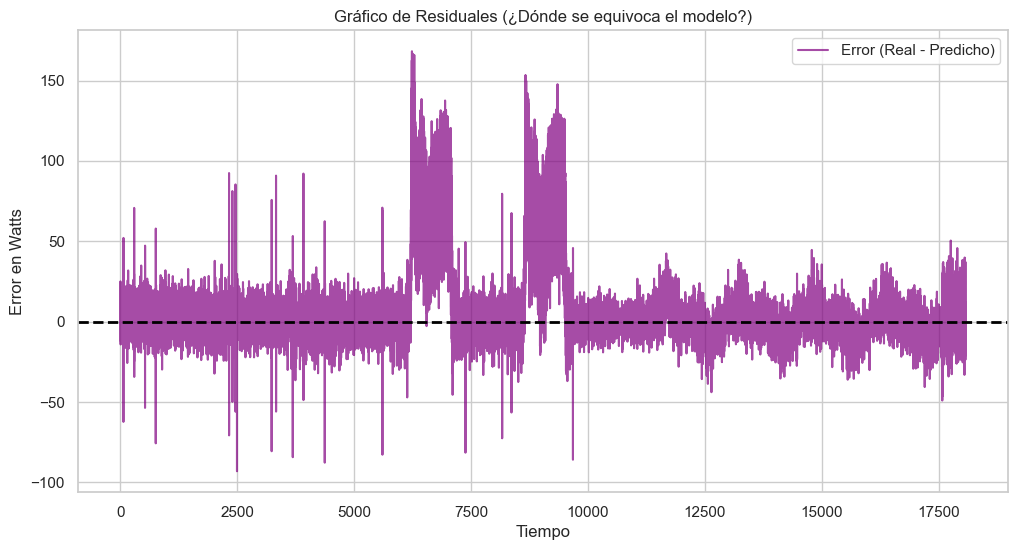

In [13]:
# Calcular el error (Residuo)
residuales = y_test_real - preds_test

plt.figure(figsize=(12, 6))
plt.plot(residuales.values, color='purple', alpha=0.7, label='Error (Real - Predicho)')
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.title("Gráfico de Residuales (¿Dónde se equivoca el modelo?)")
plt.ylabel("Error en Watts")
plt.xlabel("Tiempo")
plt.legend()
plt.show()

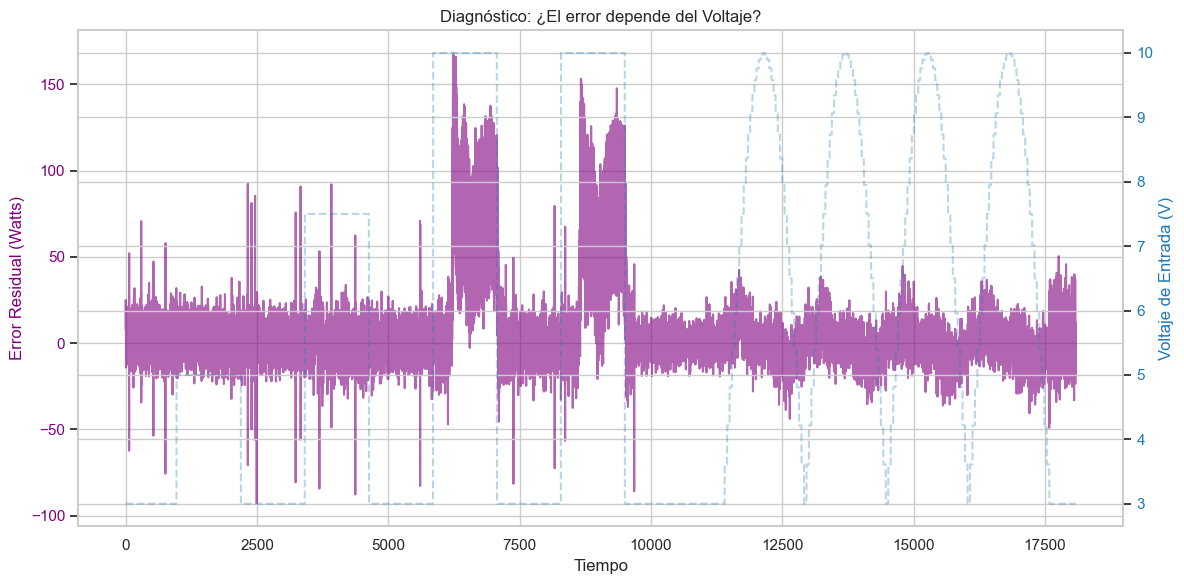

In [14]:
# Graficamos el error junto con el voltaje para ver la correlación
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'purple'
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Error Residual (Watts)', color=color)
ax1.plot(residuales.values, color=color, label='Error', alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Voltaje de Entrada (V)', color=color)
# Usamos input_voltage del dataset de test (sin escalar)
ax2.plot(X_test_real['input_voltage'].values, color=color, label='Voltaje', alpha=0.3, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Diagnóstico: ¿El error depende del Voltaje?")
fig.tight_layout() 
plt.show()

Archivos Test Cargados: ['ex_4', 'ex_22']

--- RESULTADOS FINALES (Datos Nunca Vistos) ---
RMSE: 27.48 Watts
R2 Score: 0.9988


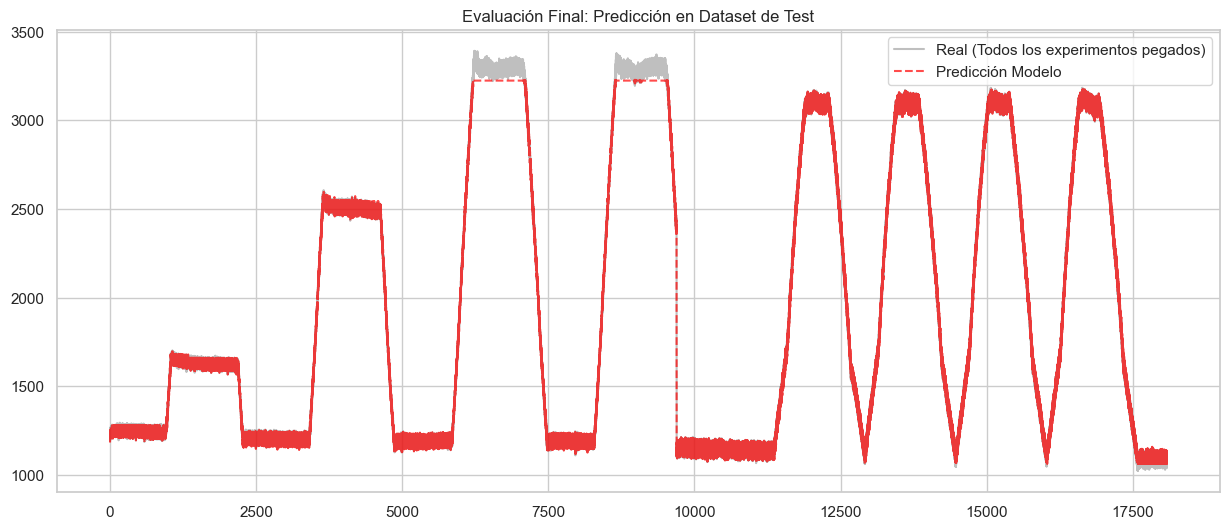

In [11]:
# --- 1. Cargar Datos de TEST ---
ruta_carpeta_test = "D:/Machine Learning/Proyectos/Micro_Gas_Turbine_Prediction/data/test"
patron_test = os.path.join(ruta_carpeta_test, "ex_*.csv")

archivos_test = glob.glob(patron_test)
archivos_test.sort(key=natural_sort_key) # Usamos tu función de ordenamiento

test_dfs = {os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f) for f in archivos_test}
print("Archivos Test Cargados:", list(test_dfs.keys()))

# --- 2. Procesar (Crear Lags) ---
# Usamos la MISMA función que definimos antes
test_procesados = crear_features(test_dfs)

# --- 3. Preparar (Unir y Separar X/y) ---
X_test_real, y_test_real = preparar_datos_finales(test_procesados)

# --- 4. Normalizar ---
# ¡OJO! Usamos 'scaler.transform', NO 'fit_transform'. 
# Queremos usar la MISMA escala que aprendimos en Train.
X_test_scaled_array = scaler.transform(X_test_real)
X_test_final = pd.DataFrame(X_test_scaled_array, columns=X_test_real.columns)

# --- 5. Predicción Final y Métricas ---
preds_test = model.predict(X_test_final)

rmse_test = np.sqrt(mean_squared_error(y_test_real, preds_test))
r2_test = r2_score(y_test_real, preds_test)

print(f"\n--- RESULTADOS FINALES (Datos Nunca Vistos) ---")
print(f"RMSE: {rmse_test:.2f} Watts")
print(f"R2 Score: {r2_test:.4f}")

# Gráfico
plt.figure(figsize=(15, 6))
plt.plot(y_test_real.values, label='Real (Todos los experimentos pegados)', alpha=0.5, color='gray')
plt.plot(preds_test, label='Predicción Modelo', alpha=0.7, color='red', linestyle='--')
plt.title("Evaluación Final: Predicción en Dataset de Test")
plt.legend()
plt.show()

In [ ]:
# 1. Guardar el Modelo
model.save_model('../models/xgboost_turbine_v1.json')
# 2. Guardar el Scaler (usando joblib)
joblib.dump(scaler, '../models/scaler_turbine_v1.pkl')
print("¡Modelo y Scaler guardados exitosamente en la carpeta 'models'!")

¡Modelo y Scaler guardados exitosamente en la carpeta 'models'!
